In [1]:
#Import required packages
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.autograd import grad
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint
import pandas as pd

itr loss theta_0 theta_1
0 0.2001 -0.1 0.1
10 0.01 -0.1035 0.1068
20 0.0099 -0.1039 0.1116
30 0.0098 -0.1029 0.1157
40 0.0098 -0.1011 0.1194
50 0.0097 -0.099 0.1231
60 0.0096 -0.0966 0.1268
70 0.0096 -0.094 0.1307
80 0.0095 -0.0912 0.1347
90 0.0094 -0.0884 0.1389
100 0.0093 -0.0854 0.1433
110 0.0093 -0.0823 0.1479
120 0.0092 -0.079 0.1527
130 0.0091 -0.0757 0.1577
140 0.009 -0.0721 0.1629
150 0.0089 -0.0685 0.1683
160 0.0088 -0.0647 0.1739
170 0.0087 -0.0607 0.1798
180 0.0086 -0.0566 0.186
190 0.0085 -0.0523 0.1923
200 0.0084 -0.0478 0.199
210 0.0083 -0.0432 0.2059
220 0.0081 -0.0384 0.2131
230 0.008 -0.0335 0.2205
240 0.0079 -0.0283 0.2283
250 0.0078 -0.023 0.2363
260 0.0077 -0.0175 0.2446
270 0.0075 -0.0118 0.2533
280 0.0074 -0.0059 0.2622
290 0.0073 0.0002 0.2715
300 0.0071 0.0065 0.2811
310 0.007 0.0129 0.291
320 0.0068 0.0196 0.3012
330 0.0067 0.0265 0.3118
340 0.0065 0.0335 0.3227
350 0.0064 0.0408 0.334
360 0.0062 0.0483 0.3456
370 0.0061 0.056 0.3576
380 0.0059 0.0638 0.3699
39

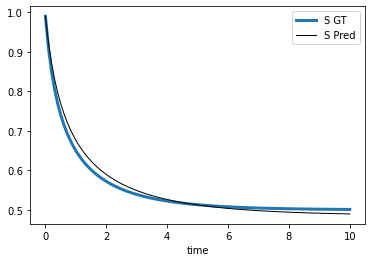

In [8]:
def loss_fun(gt, pred):
    return ((gt-pred)**2).mean()
    

class ODEFun(torch.nn.Module):
    def __init__(self):
        super(ODEFun, self).__init__()
        self.theta = torch.nn.Parameter(torch.tensor([0.0, 0.0]), requires_grad=True)
        
    def forward(self, t, y):
        S = y
        ds = self.theta[0]*S**2 - self.theta[1]*S**3
        return ds

def gt_fun(t, y):
    theta_0 = 1.0
    theta_1 = 2.0
    S = y
    ds = theta_0*S**2 - theta_1*S**3
    return ds
        
true_y0 = torch.tensor([0.99])
t = torch.linspace(0, 10, 100) 


# gt
with torch.no_grad():
    true_y = odeint(gt_fun, true_y0, t, method='dopri5')
    true_y_noise = true_y + torch.randn(true_y.shape)*0.02
    #true_y_adj = odeint_adjoint(gt_fun, true_y0, t, method='dopri5')


func = ODEFun()
lr = 0.01
num_iters = 1000
optimizer = torch.optim.RMSprop(func.parameters(), lr=lr)

losses = []
print('itr loss theta_0 theta_1')
for ii in range(num_iters): 
    
    optimizer.zero_grad()
    
    pred = odeint(func, true_y0, t, method='dopri5')
    #pred = odeint_adjoint(func, true_y0, t, method='dopri5')
    loss = loss_fun(true_y_noise, pred)
    
    loss.backward()
    optimizer.step()
    
    if ii % 10 == 0:
        print(ii, round(loss.item(), 4), round(func.theta[0].item(), 4), round(func.theta[1].item(), 4))
        losses.append(loss.item())

# Note: here the GT values are hardcoded - fix
print('\n')
print('GT  : theta_0: {:2.2}, theta_1: {:2.2}'.format(1.0, 2.0))
print('Pred: theta_0: {:2.2}, theta_1: {:2.2}'.format(round(func.theta[0].item(), 4), round(func.theta[1].item(), 4)))



plt.figure(1)
with torch.no_grad():
    plt.plot(t, true_y[:,0], 'C0', lw=3, label='S GT')
    plt.plot(t, pred[:,0], 'k', lw=1, label='S Pred')
plt.legend()
plt.xlabel('time')
plt.show()

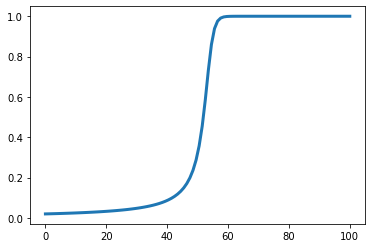

In [3]:
def gt_fun(t, y):
    theta_0 = 1.0
    theta_1 = 1.0
    S = y
    ds = theta_0*S**2 - theta_1*S**3
    return ds


delta = 0.02
y0 = torch.tensor([delta])
t = torch.linspace(0, 2/delta, 100, requires_grad=False) 

true_y = odeint(gt_fun, y0, t, method='dopri5')
plt.plot(t, true_y[:,0], 'C0', lw=3, label='S GT')